In [1]:
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)

spark = SparkSession.builder.getOrCreate()

#### Load the data

In [2]:
platform_v = "24.09"

chembl = spark.read.parquet(
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/evidence/sourceId=chembl"
)

target_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/targets/"
)
target = spark.read.parquet(target_path)

diseases_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/diseases/"
)
diseases = spark.read.parquet(diseases_path)

indications_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/indication/"
)
indications = spark.read.parquet(indications_path)

path_s01 = "gs://ot-team/jroldan/GIR_S01.csv"
nelson = spark.read.csv(path_s01, header=True)

path_mapping = "gs://ot-team/jroldan/mappings.csv"
mapping = spark.read.csv(path_mapping, header=True)

In [1]:
n = mapping.count()
print("There are", n, "mappings from EFO to MeSH terms")

NameError: name 'mapping' is not defined

#### What heppens with the obsolete terms used in the mappings Mesh-EFO?

In [3]:
diseases.select("id", F.explode_outer(F.col("dbXRefs").alias("xrefs"))).filter(
    F.col("col").contains("MeSH")
).show()

+--------------+------------+
|            id|         col|
+--------------+------------+
|   EFO_0000508|MeSH:D030342|
|   EFO_0001054|MeSH:D007918|
|   EFO_0004287|MeSH:D014693|
|   EFO_0004302|MeSH:D000886|
|   EFO_0007185|MeSH:D002006|
|   EFO_0007225|MeSH:D015605|
|   EFO_0007504|MeSH:D013587|
|   EFO_0009536|MeSH:D001762|
|   EFO_1000982|MeSH:D007177|
|   EFO_1001117|MeSH:D017562|
|   EFO_1001175|MeSH:D010302|
|   EFO_1001762|MeSH:D020211|
|   EFO_1002002|MeSH:C535833|
| Orphanet_2597|MeSH:C537476|
| Orphanet_3020|MeSH:C535287|
|Orphanet_73217|MeSH:C537371|
|   EFO_0003902|MeSH:D016103|
|   EFO_0005583|MeSH:D012279|
|   EFO_0007136|MeSH:D000377|
|   EFO_0007413|MeSH:D010002|
+--------------+------------+
only showing top 20 rows



In [19]:
diseases.filter(F.expr("exists(dbXRefs, x -> x rlike '(?i)MeSH')")).count()

6412

#### Make dataset where diseases are annotated with their respective MeSH terms. For those conflicting, we take the Mesh1.

In [3]:
diseasesWithAnnotations = (
    diseases.withColumn(
        "mesh1_flag",
        F.expr("filter(dbXRefs, x -> x rlike 'MeSH')")[
            0
        ],  # Extract the matching element
    )
    .withColumn(
        "MESH2_flag",
        F.expr("filter(dbXRefs, x -> x rlike 'MESH')")[
            0
        ],  # Extract the matching element
    )
    .withColumn("cleaned_mesh1", F.regexp_replace(F.col("mesh1_flag"), "(?i)MeSH:", ""))
    .withColumn("cleaned_mesh2", F.regexp_replace(F.col("MESH2_flag"), "(?i)MeSH:", ""))
    .withColumn(
        "equalOrNot",
        F.when(
            (F.col("cleaned_mesh1").isNotNull()) & (F.col("cleaned_mesh2").isNotNull()),
            F.when(
                F.col("cleaned_mesh1") == F.col("cleaned_mesh2"), F.lit("equal")
            ).otherwise(F.lit("diferent")),
        )
        .when(
            (F.col("cleaned_mesh1").isNotNull()) & (F.col("cleaned_mesh2").isNull()),
            F.lit("mesh1"),
        )
        .when(
            (F.col("cleaned_mesh1").isNull()) & (F.col("cleaned_mesh2").isNotNull()),
            F.lit("mesh2"),
        )
        .when(
            (F.col("cleaned_mesh1").isNull()) & (F.col("cleaned_mesh2").isNull()),
            F.lit("noData"),
        ),
    )
    .withColumn(
        "unionMesh",  ### when they are different, take the cleaned_mesh1
        F.when(F.col("equalOrNot") == "equal", F.col("cleaned_mesh1"))
        .when(F.col("equalOrNot") == "mesh1", F.col("cleaned_mesh1"))
        .when(F.col("equalOrNot") == "mesh2", F.col("cleaned_mesh2"))
        .when(F.col("equalOrNot") == "diferent", F.col("cleaned_mesh1")),
    )
    .withColumn(
        "hasMeshData",
        F.when(F.col("unionMesh").isNotNull(), F.lit("yes")).otherwise(F.lit("no")),
    )
)

In [19]:
diseases.select("id", F.explode_outer(F.col("dbXRefs").alias("xrefs"))).filter(
    F.col("col").contains("MESH")
).filter(F.col("id") == "EFO_0000508").show()

+-----------+------------+
|         id|         col|
+-----------+------------+
|EFO_0000508|MESH:D030342|
+-----------+------------+



In [12]:
diseasesWithAnnotations.groupBy("hasMeshData").count().show()

+-----------+-----+
|hasMeshData|count|
+-----------+-----+
|         no|21915|
|        yes| 6412|
+-----------+-----+



In [15]:
diseases.select("id", F.explode_outer(F.col("dbXRefs").alias("xrefs"))).filter(
    F.col("col").contains("MESH")
).show()

+-------------+------------+
|           id|         col|
+-------------+------------+
|  EFO_0000255|MESH:D007119|
|  EFO_0000508|MESH:D030342|
|  EFO_0001054|MESH:D007918|
|  EFO_0004287|MESH:D014693|
|  EFO_0007185|MESH:D002006|
|  EFO_0007225|MESH:D015605|
|  EFO_0007504|MESH:D013587|
|  EFO_0009536|MESH:D001762|
|  EFO_1000982|MESH:D007177|
|  EFO_1001117|MESH:D017562|
|  EFO_1001175|MESH:D010302|
|  EFO_1001913|MESH:D055665|
|MONDO_0002977|MESH:D020274|
|MONDO_0004532|MESH:D004428|
|MONDO_0005301|MESH:D009103|
|MONDO_0007159|MESH:C535386|
|MONDO_0007592|MESH:C565028|
|MONDO_0007683|MESH:C537293|
|MONDO_0007891|MESH:C573023|
|MONDO_0007915|MESH:D008180|
+-------------+------------+
only showing top 20 rows



#### Process datasets

In [6]:
### prepare mapping EFO-MeSH dataset  (#2,320 pairs)
mappings = (
    mapping.withColumn(
        "efo_column",
        F.regexp_replace(F.col("curie_id"), ":", "_"),  # Replaces ":" with "_"
    )
    .withColumn(
        "mesh_column",
        F.regexp_replace(
            F.col("mapped_curie"), "^MeSH:", ""
        ),  # Removes "MeSH:" from the start
    )
    .selectExpr("label", "efo_column", "mesh_column as indication_mesh_id")
)
### Get csv from Nelson and join bring EFO column to MeSH terms
nelson_efo = (
    nelson.join(mappings, on="indication_mesh_id", how="left")
    .withColumn("diseaseId", F.col("efo_column"))
    .withColumnRenamed("target", "approvedSymbol")
)
### Make chembl T-D-MaxClinPhase pairs and join with approved Symbol
chemblTD = (
    chembl.groupBy("targetId", "diseaseId")
    .agg(F.max(F.col("clinicalPhase")).alias("ChEMBL_maxClinPhase"))
    .join(
        target.selectExpr("id as targetId", "approvedSymbol"), on="targetId", how="left"
    )
)
#### Join Nelson dataset T-I-MaxClinPhase mapped to EFO with Chembl pairs
matches = nelson_efo.join(chemblTD, on=["approvedSymbol", "diseaseId"], how="outer")
matches_inner = nelson_efo.join(
    chemblTD, on=["approvedSymbol", "diseaseId"], how="inner"
)

In [8]:
nelson.count()

25713

In [15]:
nelson_efo.filter(F.col("diseaseId").isNull()).groupBy(
    "diseaseId", "combined_max_phase"
).count().show()

+---------+------------------+-----+
|diseaseId|combined_max_phase|count|
+---------+------------------+-----+
|     null|       Preclinical| 2892|
|     null|          Launched|  465|
|     null|           Phase I| 1119|
|     null|         Phase III|  476|
|     null|          Phase II| 1957|
+---------+------------------+-----+



In [17]:
# matches.toPandas().to_csv(f"gs://ot-team/jroldan/analysis/matchesNelsonChembl_all.csv")

##### Dataset with T-D with the annotation of being approved (if having at least one drug with approved drug label)

In [12]:
#### let's take the maximum (approved indication) for each target-disease
indiLabelapproved = (
    chembl.selectExpr("drugId as Id", "targetId", "diseaseId")
    .join(
        indications.select(
            "id",
            F.explode_outer(F.col("approvedIndications")).alias("diseaseId"),
        ).withColumn("approved", F.lit("approvedIndication")),
        on=["id", "diseaseId"],
        how="left",
    )
    .sort(F.col("Id").desc())
    .withColumn(
        "approvedDrugName",
        F.when(
            F.col("approved") == "approvedIndication",
            F.collect_set(F.col("Id")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        ).otherwise(F.lit(None)),
    )
    .groupBy("targetId", "diseaseId", "approved")
    .count()
    ### take T-D with at least one approved drug label
    .filter(F.col("approved") == "approvedIndication")
    .join(
        chembl.withColumn(
            "maxClinPhase",
            F.max("clinicalPhase").over(Window.partitionBy("targetId", "diseaseId")),
        )
        .select("targetId", "diseaseId", "maxClinPhase")
        .distinct(),
        on=["targetId", "diseaseId"],
        how="right",
    )
    .join(
        target.selectExpr("id as targetId", "approvedSymbol"), on="targetId", how="left"
    )
)

### Once we have the proxy of approved drug labels, we should map diseases to Mesh terms
    1. Using the dbXRefs (check number of mapped terms)

#### check numbers of T-D with mapped EFO to MEsh

In [14]:
indiLabelapproved.join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).groupBy("hasMeshData").count().show()

+-----------+-----+
|hasMeshData|count|
+-----------+-----+
|         no|31359|
|        yes|50006|
+-----------+-----+



#### Check numbers of diseases with mapped EFO to Mesh

In [15]:
indiLabelapproved.join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).select("diseaseId", "hasMeshData").distinct().groupBy("hasMeshData").count().show()

+-----------+-----+
|hasMeshData|count|
+-----------+-----+
|         no| 1294|
|        yes| 1566|
+-----------+-----+



#### Bring Nelson analysis (just interesting columns)

In [25]:
indiLabelapproved.join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).join(
    nelson.selectExpr(
        "target as approvedSymbol",
        "indication_mesh_id as unionMesh",
        "combined_max_phase",
    ),
    on=["approvedSymbol", "unionMesh"],
    how="outer",
).groupBy(
    "hasMeshData"
).count().show()

+-----------+-----+
|hasMeshData|count|
+-----------+-----+
|       null|19847|
|         no|31359|
|        yes|50006|
+-----------+-----+



In [18]:
indi_inner = indiLabelapproved.join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).join(
    nelson.selectExpr(
        "target as approvedSymbol",
        "indication_mesh_id as unionMesh",
        "combined_max_phase",
    ),
    on=["approvedSymbol", "unionMesh"],
    how="inner",
)

In [19]:
indi_inner.count()

6047

### Differences between maxClinPhase and combined_max_phase

In [22]:
indi_inner_plot = indi_inner.groupBy("maxClinPhase", "combined_max_phase").count()

In [28]:
import seaborn as sns

In [31]:
table = indi_inner.groupBy("maxClinPhase").pivot("combined_max_phase").count()

In [35]:
#### column order
col_order = [
    "maxClinPhase",
    "Phase I",
    "Phase II",
    "Phase III",
    "Preclinical",
    "Launched",
]

In [34]:
table.columns

['maxClinPhase', 'Launched', 'Phase I', 'Phase II', 'Phase III', 'Preclinical']

In [38]:
toPlotHeatmap = (
    indi_inner.groupBy("maxClinPhase")
    .pivot("combined_max_phase")
    .count()
    .select(*col_order)
    .sort(F.col("maxClinPhase").asc())
    .toPandas()
)

<AxesSubplot:>

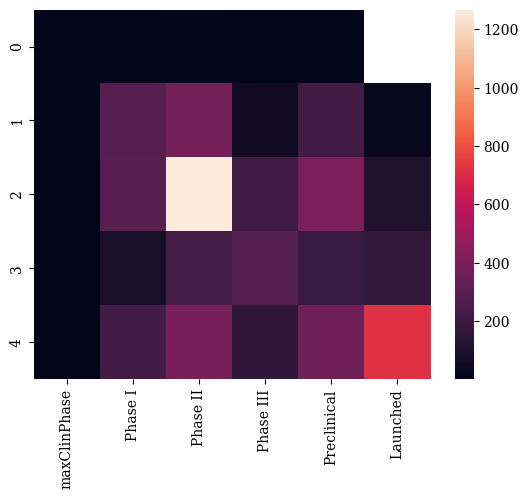

In [39]:
sns.heatmap(toPlotHeatmap)

In [27]:
glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")

NameError: name 'sns' is not defined

In [ ]:
glue

In [ ]:
glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
sns.heatmap(glue)

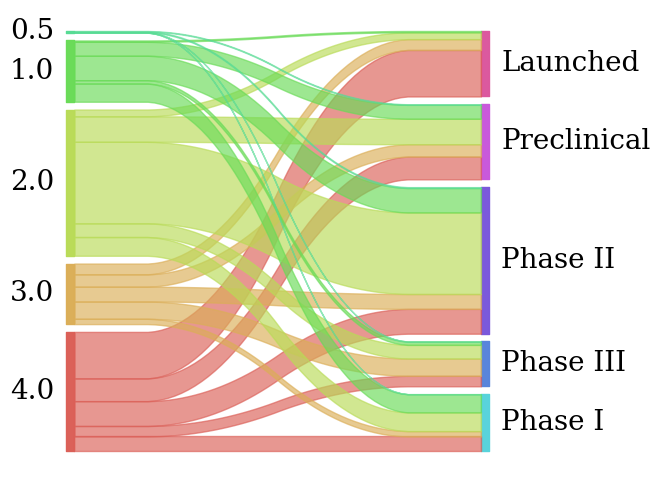

In [25]:
toPlotInner = indi_inner_plot.sort(F.col("maxClinPhase").desc()).toPandas()

sankey(
    left=toPlotInner["maxClinPhase"],
    right=toPlotInner["combined_max_phase"],
    leftWeight=toPlotInner["count"],
    rightWeight=toPlotInner["count"],
    aspect=20,
    fontsize=20,
)

##### Count combination sof max clin phase, approved and combined max clin phase from Nelson 

In [29]:
indiLabelapproved.join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).join(
    nelson.selectExpr(
        "target as approvedSymbol",
        "indication_mesh_id as unionMesh",
        "combined_max_phase",
    ),
    on=["approvedSymbol", "unionMesh"],
    how="outer",
).groupBy(
    "approved", "combined_max_phase", "maxClinPhase"
).count().show()

+------------------+------------------+------------+-----+
|          approved|combined_max_phase|maxClinPhase|count|
+------------------+------------------+------------+-----+
|approvedIndication|              null|         1.0|   45|
|approvedIndication|       Preclinical|         3.0|    1|
|              null|           Phase I|         1.0|  283|
|approvedIndication|          Launched|         2.0|    9|
|approvedIndication|              null|         3.0|  454|
|approvedIndication|       Preclinical|         4.0|  193|
|              null|          Phase II|         2.0| 1265|
|              null|         Phase III|         1.0|   52|
|approvedIndication|          Phase II|         3.0|    1|
|approvedIndication|          Phase II|         2.0|    3|
|approvedIndication|           Phase I|         2.0|    1|
|              null|          Phase II|         0.5|   14|
|              null|       Preclinical|         2.0|  395|
|approvedIndication|       Preclinical|         2.0|    

In [34]:
!pip install pySankey

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pySankey from https://files.pythonhosted.org/packages/ad/fc/c2823db63e0efe3652759a4de2859ed02fe5479bb1ba720605cd789121e5/pySankey-0.0.1-py3-none-any.whl.metadata


In [21]:
import pandas as pd
from pySankey.sankey import sankey

In [61]:
df2 = (
    indiLabelapproved.join(
        diseasesWithAnnotations.selectExpr(
            "id as diseaseId", "unionMesh", "hasMeshData"
        ),
        on="diseaseId",
        how="left",
    )
    .join(
        nelson.selectExpr(
            "target as approvedSymbol",
            "indication_mesh_id as unionMesh",
            "combined_max_phase",
        ),
        on=["approvedSymbol", "unionMesh"],
        how="outer",
    )
    .groupBy(
        "approved",
        "combined_max_phase",
    )
    # "maxClinPhase")
    .count()
    .withColumn(
        "approved",
        F.when(F.col("approved").isNull(), F.lit("noApproved")).otherwise(
            F.lit("approved")
        ),
    )
    .filter(
        # (F.col("maxClinPhase").isNotNull())
        (F.col("count").isNotNull())
        & (F.col("combined_max_phase").isNotNull())
    )
    .toPandas()
)

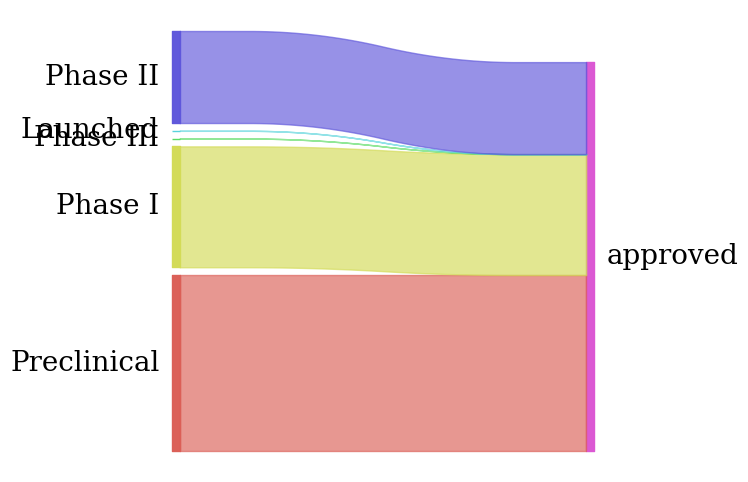

In [67]:
df3 = df2[(df2["approved"] == "approved")]

sankey(
    left=df3["combined_max_phase"],
    right=df3["approved"],
    leftWeight=df3["count"],
    rightWeight=df3["count"],
    aspect=20,
    fontsize=20,
)

In [47]:
df2

,approved,combined_max_phase,count
0,approved,Preclinical,195
1,approved,Phase I,134
4,approved,Phase III,102
5,approved,Launched,636
8,approved,Phase II,218


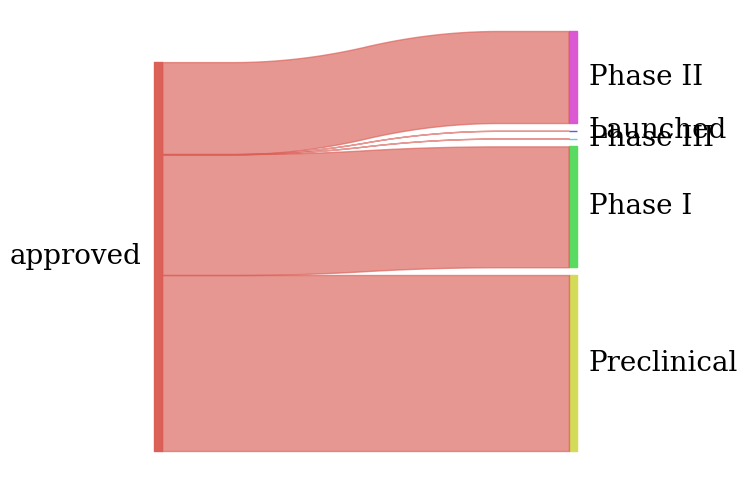

In [57]:
sankey(
    left=df2["approved"],
    right=df2["combined_max_phase"],
    leftWeight=df2["count"],
    rightWeight=df2["count"],
    aspect=20,
    fontsize=20,
)

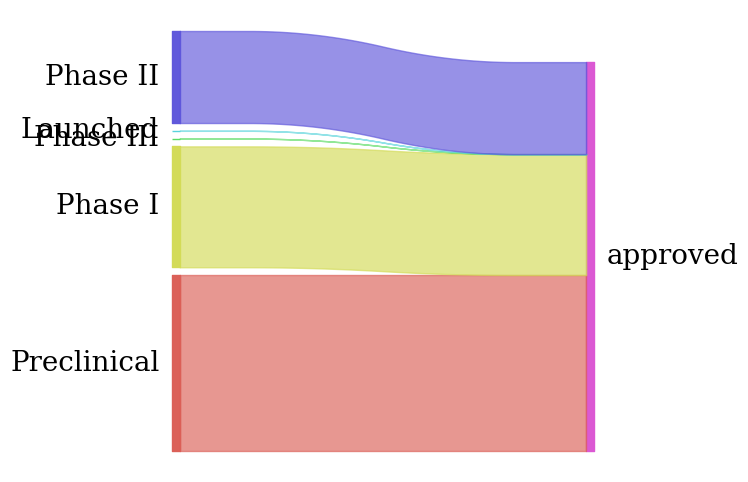

In [44]:
df3 = df2[(df2["approved"] == "approved")]
sankey(
    left=df3["combined_max_phase"],
    right=df3["approved"],
    leftWeight=df3["count"],
    rightWeight=df3["count"],
    aspect=20,
    fontsize=20,
)

In [27]:
indiLabelapproved.join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).join(
    nelson.selectExpr(
        "target as approvedSymbol",
        "indication_mesh_id as unionMesh",
        "combined_max_phase",
    ),
    on=["approvedSymbol", "unionMesh"],
    how="outer",
).groupBy(
    "maxClinPhase", "approved", "combined_max_phase", "hasMeshData"
).count().show()

+------------+------------------+------------------+-----------+-----+
|maxClinPhase|          approved|combined_max_phase|hasMeshData|count|
+------------+------------------+------------------+-----------+-----+
|         4.0|              null|          Launched|        yes|  105|
|         4.0|              null|       Preclinical|        yes|  161|
|         4.0|              null|           Phase I|        yes|   94|
|         3.0|              null|          Launched|        yes|  159|
|         0.5|              null|           Phase I|        yes|    2|
|         3.0|              null|              null|        yes| 7307|
|         1.0|              null|          Launched|        yes|   21|
|         2.0|              null|              null|        yes|15232|
|         3.0|approvedIndication|          Launched|        yes|    9|
|         4.0|approvedIndication|              null|        yes| 3174|
|         2.0|              null|         Phase III|        yes|  213|
|     

In [49]:
indiLabelapproved.groupBy("maxClinPhase", "approved").count().sort(
    F.col("maxClinPhase").desc()
).sort(F.col("maxClinPhase").asc(), F.col("approved").desc()).show()

+------------+------------------+-----+
|maxClinPhase|          approved|count|
+------------+------------------+-----+
|         0.5|approvedIndication|    1|
|         0.5|              null| 1285|
|         1.0|approvedIndication|   45|
|         1.0|              null|13960|
|         2.0|approvedIndication|  308|
|         2.0|              null|29679|
|         3.0|approvedIndication|  466|
|         3.0|              null|13725|
|         4.0|approvedIndication| 6387|
|         4.0|              null|15509|
+------------+------------------+-----+



In [50]:
indiLabelapproved.groupBy("approved").pivot("maxClinPhase").count().show()

+------------------+----+-----+-----+-----+-----+
|          approved| 0.5|  1.0|  2.0|  3.0|  4.0|
+------------------+----+-----+-----+-----+-----+
|approvedIndication|   1|   45|  308|  466| 6387|
|              null|1285|13960|29679|13725|15509|
+------------------+----+-----+-----+-----+-----+



In [24]:
chemblTD.join(indiLabelapproved, on=["targetId", "diseaseId"], how="left").join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).join(
    target.selectExpr("id as targetId", "approvedSymbol"), on="targetId", how="left"
).join(
    nelson.withColumn("hasNelson", F.lit("hasNelson")).selectExpr(
        "target as approvedSymbol",
        "indication_mesh_id as unionMesh",
        "combined_max_phase",
        "hasNelson",
    ),
    on=["approvedSymbol", "unionMesh"],
    how="left",
).groupBy(
    "approved", "combined_max_phase"
).count().sort(
    F.col("approved")
).show()

+------------------+------------------+-----+
|          approved|combined_max_phase|count|
+------------------+------------------+-----+
|              null|              null|69396|
|              null|          Launched|  382|
|              null|           Phase I|  751|
|              null|       Preclinical|  973|
|              null|         Phase III|  595|
|              null|          Phase II| 2061|
|approvedIndication|       Preclinical|  195|
|approvedIndication|              null| 5922|
|approvedIndication|          Phase II|  218|
|approvedIndication|           Phase I|  134|
|approvedIndication|         Phase III|  102|
|approvedIndication|          Launched|  636|
+------------------+------------------+-----+



In [ ]:
chemblTD.join(indiLabel, on=["targetId", "diseaseId"], how="left").join(
    diseasesWithAnnotations.selectExpr("id as diseaseId", "unionMesh", "hasMeshData"),
    on="diseaseId",
    how="left",
).join

In [9]:
indiLabel.count()

7207

In [10]:
#####

###

#####

In [17]:
indications.filter(F.col("Id") == "CHEMBL52885").show(truncate=False)

+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------+
|id         |indications                                                                                                                                                                                                                                                                                                                                                                                                                                                            |approvedIndications|indic

In [7]:
#####
indications.select(
    "id", F.explode_outer("indications").alias("indications"), "approvedIndications"
).select(
    "id", "indications.*", F.explode_outer("approvedIndications").alias("approved")
).show()

### Make explosion of the indications and take the maximum clinical phase
###

+-------------+-------------+--------------------+--------------------+---------------------+--------------------+
|           id|      disease|             efoName|          references|maxPhaseForIndication| approvedIndications|
+-------------+-------------+--------------------+--------------------+---------------------+--------------------+
|CHEMBL1200796|MONDO_0019391|      fanconi anemia|[{ClinicalTrials,...|                  2.0|[MONDO_0009348, E...|
|CHEMBL1200796|  EFO_0008498|  clear cell sarcoma|[{ClinicalTrials,...|                  1.0|[MONDO_0009348, E...|
|CHEMBL1200796|  EFO_0005952|non-hodgkins lymp...|[{ClinicalTrials,...|                  3.0|[MONDO_0009348, E...|
|CHEMBL1200796|  EFO_0002087|        fibrosarcoma|[{ClinicalTrials,...|                  1.0|[MONDO_0009348, E...|
|CHEMBL1200796|  EFO_0001642|   lymphoid neoplasm|[{ClinicalTrials,...|                  2.0|[MONDO_0009348, E...|
|CHEMBL1200796|  EFO_1001779|chronic myelomono...|[{ClinicalTrials,...|         

In [5]:
indications.select(
    "id", F.explode_outer("approvedIndications").alias("approvedIndications")
).select("id", "approvedIndications").withColumn(
    "launchedIndication", F.lit("launched")
).show()

+-------------+-------------------+------------------+
|           id|approvedIndications|launchedIndication|
+-------------+-------------------+------------------+
|CHEMBL1200796|      MONDO_0009348|          launched|
|CHEMBL1200796|        EFO_0000616|          launched|
|CHEMBL1200796|        EFO_0003869|          launched|
|CHEMBL1200796|        EFO_1000294|          launched|
|CHEMBL1200796|        EFO_0004255|          launched|
|CHEMBL1200796|        EFO_0000574|          launched|
|CHEMBL1200796|      MONDO_0004992|          launched|
|CHEMBL1200796|      MONDO_0007254|          launched|
|CHEMBL1200796|        EFO_0001378|          launched|
|CHEMBL1200796|        EFO_0000183|          launched|
|CHEMBL1200796|        EFO_0000305|          launched|
|CHEMBL1201581|        EFO_0000729|          launched|
|CHEMBL1201581|        EFO_0000685|          launched|
|CHEMBL1201581|        EFO_0003898|          launched|
|CHEMBL1201581|        EFO_0000676|          launched|
|CHEMBL120

#### Count N of T-I with Maximum clinical trials different between ChEMBL evidences and Pharmaprojects

In [5]:
matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(
    F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()
).groupBy(
    "combinedPhase", "maxClinPhase"
).count().withColumn(
    "differences",
    F.when(F.col("combinedPhase") == F.col("maxClinPhase"), F.lit("equal"))
    .when(F.col("combinedPhase") > F.col("maxClinPhase"), F.lit("Nelson>>Chembl"))
    .when(F.col("combinedPhase") < F.col("maxClinPhase"), F.lit("Nelson<<Chembl")),
).sort(
    F.col("differences").desc()
).groupBy(
    "differences"
).agg(
    F.sum(F.col("count"))
).show(
    100
)

+--------------+----------+
|   differences|sum(count)|
+--------------+----------+
|         equal|      1835|
|Nelson<<Chembl|      1912|
|Nelson>>Chembl|       701|
+--------------+----------+



#### See changes between clinical phases between datasets

In [6]:
matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(
    F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()
).groupBy(
    "combinedPhase", "maxClinPhase"
).count().withColumn(
    "differences",
    F.when(F.col("combinedPhase") == F.col("maxClinPhase"), F.lit("equal"))
    .when(F.col("combinedPhase") > F.col("maxClinPhase"), F.lit("Nelson>>Chembl"))
    .when(F.col("combinedPhase") < F.col("maxClinPhase"), F.lit("Nelson<<Chembl")),
).filter(
    F.col("differences") != "equal"
).sort(
    F.col("combinedPhase").asc()
).show(
    100
)

+-------------+------------+-----+--------------+
|combinedPhase|maxClinPhase|count|   differences|
+-------------+------------+-----+--------------+
|          0.5|         4.0|  309|Nelson<<Chembl|
|          0.5|         3.0|  136|Nelson<<Chembl|
|          0.5|         2.0|  257|Nelson<<Chembl|
|          0.5|         1.0|  164|Nelson<<Chembl|
|          1.0|         0.5|    1|Nelson>>Chembl|
|          1.0|         4.0|  189|Nelson<<Chembl|
|          1.0|         2.0|  192|Nelson<<Chembl|
|          1.0|         3.0|   59|Nelson<<Chembl|
|          2.0|         4.0|  301|Nelson<<Chembl|
|          2.0|         1.0|  320|Nelson>>Chembl|
|          2.0|         3.0|  173|Nelson<<Chembl|
|          2.0|         0.5|    7|Nelson>>Chembl|
|          3.0|         1.0|   32|Nelson>>Chembl|
|          3.0|         0.5|    1|Nelson>>Chembl|
|          3.0|         2.0|  145|Nelson>>Chembl|
|          3.0|         4.0|  132|Nelson<<Chembl|
|          4.0|         2.0|   74|Nelson>>Chembl|


#### Print diseases from T-D where Pharmaprojects is preclinical and ChEMBL appears approved

In [60]:
matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()).filter(
    (F.col("combinedPhase") == 0.5) & (F.col("maxClinPhase") == 4.0)
).groupBy(
    "label"
).count().sort(
    F.col("count").desc()
).show(
    309, truncate=False
)

+----------------------------------------+-----+
|label                                   |count|
+----------------------------------------+-----+
|immune system disease                   |36   |
|neoplasm                                |30   |
|cardiovascular disease                  |25   |
|diabetes mellitus                       |12   |
|obesity                                 |10   |
|epilepsy                                |10   |
|post-traumatic stress disorder          |8    |
|atherosclerosis                         |8    |
|inflammatory bowel disease              |5    |
|heart failure                           |5    |
|mental or behavioural disorder          |5    |
|chronic obstructive pulmonary disease   |5    |
|myocardial infarction                   |4    |
|insomnia                                |4    |
|Hepatitis, Alcoholic                    |4    |
|atrial fibrillation                     |4    |
|blood coagulation disease               |4    |
|non-small cell lung

#### Print genes from T-D where Pharmaprojects is preclinical and ChEMBL appears approved

In [61]:
matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()).filter(
    (F.col("combinedPhase") == 0.5) & (F.col("maxClinPhase") == 4.0)
).groupBy(
    "approvedSymbol"
).count().sort(
    F.col("count").desc()
).show(
    309, truncate=False
)

+--------------+-----+
|approvedSymbol|count|
+--------------+-----+
|NR3C1         |11   |
|PTGS2         |8    |
|PTGS1         |6    |
|CNR1          |5    |
|ESR1          |5    |
|PGF           |5    |
|ACE           |4    |
|GRIN1         |4    |
|OPRM1         |4    |
|PPARG         |4    |
|ADORA2B       |4    |
|HMGCR         |4    |
|VEGFA         |3    |
|ADRA2A        |3    |
|OPRD1         |3    |
|AGTR1         |3    |
|VDR           |3    |
|PDE3A         |3    |
|ADORA3        |3    |
|HRH1          |3    |
|TRPV1         |3    |
|SLC5A2        |3    |
|RXRG          |2    |
|GABRA4        |2    |
|FKBP1A        |2    |
|SLC6A4        |2    |
|PGR           |2    |
|CRBN          |2    |
|SCN5A         |2    |
|MT-ND1        |2    |
|HTR3A         |2    |
|PDE10A        |2    |
|ABAT          |2    |
|TUBB          |2    |
|SCN1A         |2    |
|TNF           |2    |
|TNFSF13B      |2    |
|IFNG          |2    |
|PDE4A         |2    |
|MS4A1         |2    |
|AR        

#### See cases where Pharmaprojects is phaseIV (launched) and ChEMBL below it.

In [63]:
### cases where Nelson is Phase 4 and Chembl below 4
matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()).filter(
    (F.col("combinedPhase") == 4.0) & (F.col("maxClinPhase") < 4.0)
).show(
    309, truncate=False
)

+--------------+-----------+------------------+---------------+---------------------------------+--------------------------------------+--------------------+----------------+------------------+--------+--------+--------+--------+------+-----------+-------------+-------------------------------------------+------------+--------------------------------------------+----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+----------+------------+--------+-------------+---------+--------+-----------+----------+-----------+----------+-----------+------------------------------------------------------+---------------+----------------------------+------------+------------+-----------+----------------+------+-----------+------+-------------------------------------+-----------+---------------+------------+-----------

#### Print diseases from T-D where Pharmaprojects is launched and ChEMBL appears below

In [62]:
### Diseases from cases where Nelson is Phase 4 and Chembl below 2

matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()).filter(
    (F.col("combinedPhase") == 4.0) & (F.col("maxClinPhase") < 4.0)
).groupBy(
    "label"
).count().sort(
    F.col("count").desc()
).show(
    309, truncate=False
)

+-------------------------------------+-----+
|label                                |count|
+-------------------------------------+-----+
|non-small cell lung carcinoma        |14   |
|kidney neoplasm                      |14   |
|liver neoplasm                       |13   |
|acute myeloid leukemia               |11   |
|pancreatic neoplasm                  |10   |
|ovarian neoplasm                     |9    |
|stomach neoplasm                     |7    |
|breast neoplasm                      |6    |
|small cell lung carcinoma            |6    |
|Behcet's syndrome                    |5    |
|endometrial neoplasm                 |5    |
|status epilepticus                   |4    |
|non-Hodgkins lymphoma                |4    |
|colorectal neoplasm                  |4    |
|ventricular fibrillation             |3    |
|thyroid neoplasm                     |3    |
|melanoma                             |3    |
|Vitiligo                             |2    |
|chronic lymphocytic leukemia     

#### Print genes from T-D where Pharmaprojects is launched and ChEMBL appears below

In [65]:
### Targets from cases where Nelson is Phase 4 and Chembl below 2

matches.withColumn(
    "combinedPhase",
    F.when(F.col("combined_max_phase") == "Preclinical", F.lit(0.5))
    .when(F.col("combined_max_phase") == "Phase I", F.lit(1.0))
    .when(F.col("combined_max_phase") == "Phase II", F.lit(2.0))
    .when(F.col("combined_max_phase") == "Phase III", F.lit(3.0))
    .when(F.col("combined_max_phase") == "Launched", F.lit(4.0)),
).filter(F.col("combinedPhase").isNotNull() & F.col("maxClinPhase").isNotNull()).filter(
    (F.col("combinedPhase") == 4.0) & (F.col("maxClinPhase") < 4.0)
).groupBy(
    "approvedSymbol"
).count().sort(
    F.col("count").desc()
).show(
    309, truncate=False
)

+--------------+-----+
|approvedSymbol|count|
+--------------+-----+
|FGFR1         |8    |
|FLT1          |7    |
|KIT           |6    |
|BRAF          |6    |
|FGFR3         |6    |
|PDCD1         |6    |
|IL2RA         |5    |
|KDR           |5    |
|FLT4          |5    |
|TOP2A         |5    |
|CD274         |4    |
|BTK           |4    |
|RET           |4    |
|PDGFRA        |4    |
|FGFR2         |4    |
|ABCB1         |4    |
|NR3C1         |4    |
|VEGFA         |3    |
|PDGFRB        |3    |
|IL17RA        |3    |
|JAK1          |3    |
|FGFR4         |3    |
|FLT3          |3    |
|IL1B          |2    |
|IL17F         |2    |
|ERBB4         |2    |
|F10           |2    |
|TUBB          |2    |
|CD3E          |2    |
|PIK3CD        |2    |
|PPARA         |2    |
|CSF1R         |2    |
|IL4R          |2    |
|APOC3         |2    |
|JAK3          |2    |
|TEK           |2    |
|MAP2K2        |2    |
|MAP2K1        |2    |
|LYN           |2    |
|CHRM1         |1    |
|TOP1      